### importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_parquet(r"C:\Users\boluy\Downloads\TERM 03\AML 3303\projects\Staywise-Airbnb-Pricing\data\sample_features.parquet")

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review_month,last_review_year,host_more_than_one_listing,host_many_listings,log_price,is_high_availability,is_popular,reviews_x_minimum_nights,availability_x_reviews,room_latitude
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,10.0,2018.0,1,1,5.010635,1,1,9,76.65,40.64749
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,5.0,2019.0,1,0,5.420535,1,1,45,134.90,0.00000
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,NaN,NaN,0,0,5.017280,1,0,0,0.00,40.80902
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,7.0,2019.0,0,0,4.499810,1,1,270,900.16,0.00000
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,11.0,2018.0,0,0,4.394449,0,1,90,0.00,0.00000


## Modeling

### MLflow + Train Baseline Models
MLflow Setup, Baseline Models, and Summary



In [3]:
import os
import sys
from dotenv import load_dotenv
import joblib
from sklearn.model_selection import train_test_split

project_root_path = r"C:\Users\boluy\Downloads\TERM 03\AML 3303\projects\Staywise-Airbnb-Pricing" 
dotenv_path = os.path.join(project_root_path, '.env')

if project_root_path not in sys.path:
    sys.path.insert(0, project_root_path)
    print(f" Path Fix: Project Root added to sys.path: {project_root_path}")
    
# Load Environment and Force S3 Path
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
    os.environ["S3_PATH"] = "s3://my-airbnb-pricing/AB_NYC_2019.csv"
    print(" Environment: S3_PATH forced to correct value.")

#  Imports 
import src.data as data
import src.process as process 
print("\n All core modules (src.data, src.process) imported.")


# Data Load, Clean, and Split ---
print("\n--- Starting Data Processing ---")
raw_df = data.load_from_s3()
processed_df = process.clean_and_feature_engineer(raw_df)

# Define features (X) and target (y)
X = processed_df.drop(columns=['price', 'log_price'])
y = processed_df['log_price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Data split successfully. X_train shape: {X_train.shape}")


# Build, Save, and Test Preprocessor

# a) Build and Fit Preprocessor
print("\nFitting preprocessor on X_train...")
preprocessor = process.build_preprocessor(X_train)
preprocessor.fit(X_train) # Explicitly fit the transformer

# b) Save Preprocessor
preprocessor_path = os.path.join(project_root_path, 'artifacts', 'airbnb_preprocessor.joblib')
os.makedirs(os.path.dirname(preprocessor_path), exist_ok=True)
process.save_preprocessor(preprocessor, preprocessor_path)
print(f" Preprocessor saved to: {preprocessor_path}")

# c) Transformation Tests
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\nFinal X_train transformed shape: {X_train_transformed.shape}")
print(f"Final X_test transformed shape: {X_test_transformed.shape}")

if X_train_transformed.shape[1] == X_test_transformed.shape[1]:
    print("\n FINAL SUCCESS: Preprocessing pipeline built and tested. Features match!")
else:
    print(" ERROR: Feature shapes do not match after transformation. Check your OHE categories.")

 Path Fix: Project Root added to sys.path: C:\Users\boluy\Downloads\TERM 03\AML 3303\projects\Staywise-Airbnb-Pricing
 Environment: S3_PATH forced to correct value.

 All core modules (src.data, src.process) imported.

--- Starting Data Processing ---
Data after cleaning has 48569 rows and 14 columns.
Data split successfully. X_train shape: (38855, 12)

Fitting preprocessor on X_train...
 Preprocessor saved to: C:\Users\boluy\Downloads\TERM 03\AML 3303\projects\Staywise-Airbnb-Pricing\artifacts\airbnb_preprocessor.joblib

Final X_train transformed shape: (38855, 238)
Final X_test transformed shape: (9714, 238)

 FINAL SUCCESS: Preprocessing pipeline built and tested. Features match!


In [4]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from mlflow.models.signature import infer_signature

mlflow.set_tracking_uri("http://127.0.0.1:5000")   # local MLflow server
mlflow.set_experiment("StayWise Airbnb Pricing")

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        random_state=42
    )
}

X_train_t = X_train_transformed
X_test_t = X_test_transformed

# Ensure X_train_t/X_test_t are DataFrames for logging
if not isinstance(X_train_t, pd.DataFrame):
    X_train_t = pd.DataFrame(X_train_t)
if not isinstance(X_test_t, pd.DataFrame):
    X_test_t = pd.DataFrame(X_test_t)

results = []

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        
        # Train
        model.fit(X_train_t, y_train)
        preds = model.predict(X_test_t)

        # Metrics (RMSE compatible with all scikit-learn versions)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, preds)

        # Log Params (if model has any)
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())

        # Log Metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)

        # Infer model signature
        signature = infer_signature(X_train_t, model.predict(X_train_t))

        # Log model with name, signature, and input example
        mlflow.sklearn.log_model(
            sk_model=model,
            name=model_name,
            signature=signature,
            input_example=X_train_t.head(5)
        )

        print(f"{model_name} → RMSE: {rmse:.4f}, R2: {r2:.4f}")

        results.append((model_name, rmse, r2))

# Create a summary DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"])
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)

print("\n Model Comparison Summary (sorted by RMSE):")
print(results_df)


C:\Users\boluy\anaconda3\envs\shap_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LinearRegression → RMSE: 0.4283, R2: 0.5738
🏃 View run LinearRegression at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/bc7a2b2f2fde42558ff7ad4b052b69de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588


Ridge → RMSE: 0.4278, R2: 0.5746
🏃 View run Ridge at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/34ba1ec935c1468da886f3c27a22ee6c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588


Lasso → RMSE: 0.4338, R2: 0.5626
🏃 View run Lasso at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/5267ed5f12b141278399c755160f0ef1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588


RandomForest → RMSE: 0.3967, R2: 0.6344
🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/65b9044efbce41ae9be8eb42d5ac0aef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588

 Model Comparison Summary (sorted by RMSE):
              Model      RMSE        R2
0      RandomForest  0.396665  0.634352
1             Ridge  0.427841  0.574617
2  LinearRegression  0.428260  0.573783
3             Lasso  0.433836  0.562611


### Observation
The Random Forest model is the best performer, achieving the lowest error (lowest RMSE of $0.397$) and explaining the most variance (highest R2 of $0.634$) among the compared models. The performance difference between Random Forest and the linear models (Ridge, Linear Regression, Lasso) is significant.

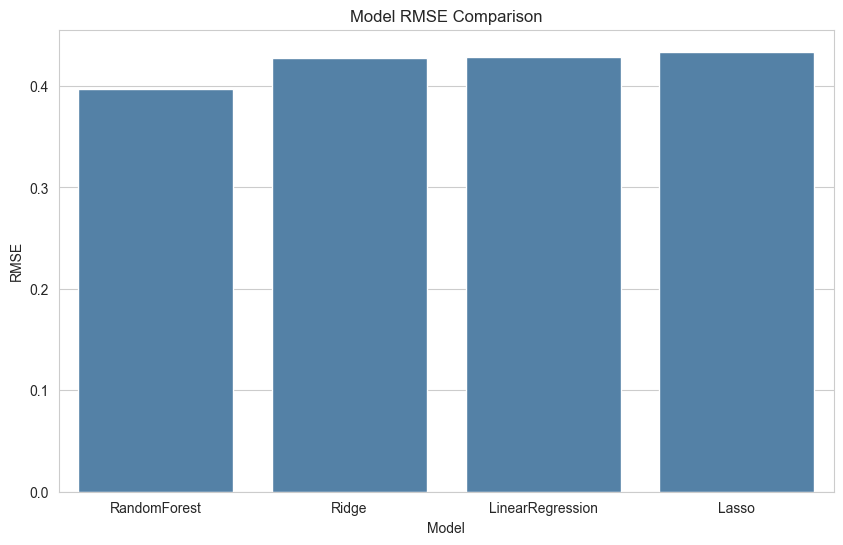

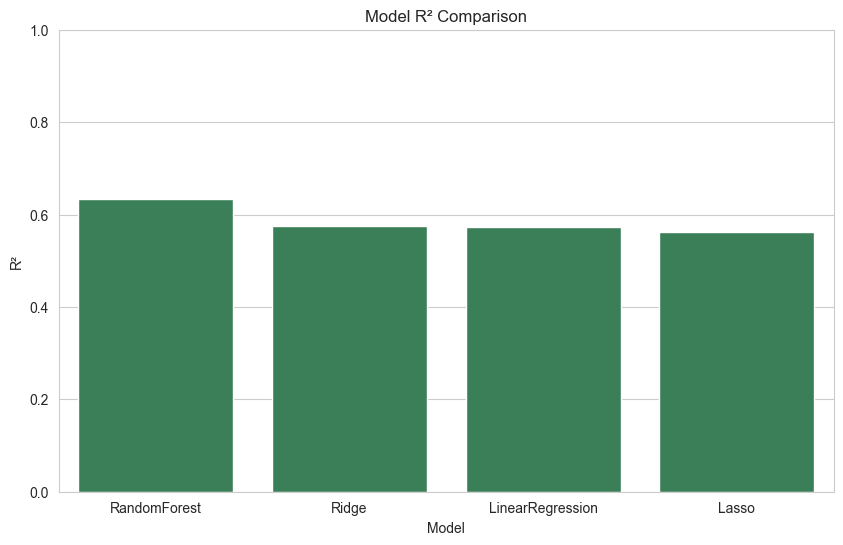

In [5]:
# Visualization
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

# RMSE bar chart
sns.barplot(x="Model", y="RMSE", data=results_df, color="steelblue")
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()

# R² bar chart
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="R2", data=results_df, color="seagreen")
plt.title("Model R² Comparison")
plt.ylabel("R²")
plt.xlabel("Model")
plt.ylim(0, 1)  # R² ranges from 0 to 1
plt.show()


### Cell: Select Best Model + Register It

In [10]:
# Pick Best Model Automatically

sorted_results = sorted(results, key=lambda x: x[1])  # sort by RMSE ascending
best_model_name, best_rmse, best_r2 = sorted_results[0]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse}, R2: {best_r2}")

mlflow.set_experiment("StayWise Airbnb Pricing")

with mlflow.start_run(run_name="RegisterBestModel"):
    best_model = models[best_model_name]
    mlflow.sklearn.log_model(best_model, name="best_airbnb_price_model")
    mlflow.log_metric("best_rmse", best_rmse)
    mlflow.log_metric("best_r2", best_r2)



🏆 BEST MODEL: RandomForest
RMSE: 0.3966649755014901, R2: 0.6343515257887042


2025/11/23 20:46:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RegisterBestModel at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/63f326c950e44c5db4a88982876698e6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588


In [7]:
# Assume X_train_t (X_train_transformed) holds fully processed, numerical training data

# 1. Use a sample from the *transformed* input data (X_train_t)
sample_input = X_train_t.head(5)

# 2. The model signature calculation is now safe, as 'predict' receives numerical data
signature = infer_signature(sample_input, best_model.predict(sample_input))

with mlflow.start_run(run_name="RegisterBestModel"):
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="best_airbnb_price_model",
        signature=signature,
        input_example=sample_input # Use the transformed numerical input example
    )
    mlflow.log_metric("best_rmse", best_rmse)
    mlflow.log_metric("best_r2", best_r2)



2025/11/23 17:25:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RegisterBestModel at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/ad954e83c3ab468a8c385369281af7a9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588


### 1 categorical columns identification

In [48]:
categorical_cols = X.select_dtypes(include=['object']).columns
print(categorical_cols)


Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')


### Train model on encoded features

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Identify categorical columns
cat_cols = ['neighbourhood_group', 'neighbourhood', 'room_type', 'review_frequency_bucket']

# Identify numeric columns
num_cols = [col for col in X.columns if col not in cat_cols]

# Build preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Build full model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocess),
    ('regressor', RandomForestRegressor())
])

model.fit(X, y)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Pipeline Summary
The system uses a $\text{Pipeline}$ to sequentially apply preprocessing steps and then fit a Random Forest Regressor model. The $\text{preprocessing}$ stage handles different data types using a $\text{ColumnTransformer}$: it applies One-Hot Encoding to categorical features and leaves the numerical features unchanged ($\text{passthrough}$).
#### Interpretation of the Pipeline 
ArchitectureThe diagram clearly illustrates a robust and best-practice structure for model training, leveraging Scikit-learn's tools:

##### 1. Outer Pipeline
   The outermost box labeled Pipeline sequences the entire workflow. This ensures that the preprocessing steps are applied immediately before the model fitting, and critically, it prevents data leakage during cross-validation by only applying the fit method on the training data within each fold

##### 2. Preprocessor:  ColumnTransformer 
The $\text{preprocessor}$ step is a $\text{ColumnTransformer}$. This powerful tool allows you to apply different transformers to different subsets of your input features based on their type (or name).Categorical Features ($\text{cat}$): These features are passed to a $\text{OneHotEncoder}$. This process converts each unique category into a new binary (0 or 1) column, making the categorical data suitable for the $\text{RandomForestRegressor}$.Numerical Features ($\text{num}$): These features are handled using $\text{passthrough}$. This means the numerical columns are included in the final preprocessed output dataset without any transformation (no scaling, no imputation shown here).
   
##### 3. Estimator: RandomForestRegressor
   The final step in the $\text{Pipeline}$ is the $\text{RandomForestRegressor}$.Input: This model receives the combined, preprocessed data (the newly created One-Hot encoded columns plus the original numerical columns).Action: It fits the ensemble model to the data to make continuous predictions (a regression task).

### Save Model Locally

In [36]:
# Cell 4: Save Best Model Locally
best_model_path = os.path.join(project_root_path, "artifacts", "best_price_model.joblib")
joblib.dump(best_model, best_model_path)

print("Best model saved to:", best_model_path)


Best model saved to: C:\Users\boluy\Downloads\TERM 03\AML 3303\projects\Staywise-Airbnb-Pricing\artifacts\best_price_model.joblib


### Model Explainability & Validation

#### 1. Setup & Imports

In [11]:
# Model Explainability & Validation

import os
import mlflow
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

from sklearn.metrics import mean_squared_error, r2_score


### 2. Load Best Model from MLflow



In [9]:
# Load the best model from MLflow

best_run_id = "ad954e83c3ab468a8c385369281af7a9"  

# CORRECTED PATH: Use 'best_airbnb_price_model' instead of 'model'
model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/best_airbnb_price_model")

print("Model loaded successfully from MLflow.")

Model loaded successfully from MLflow.


### 3. Load Preprocessor

In [42]:
preprocessor_path = r"C:\Users\boluy\Downloads\TERM 03\AML 3303\projects\Staywise-Airbnb-Pricing\artifacts\airbnb_preprocessor.joblib"
preprocessor = joblib.load(preprocessor_path)

print("Preprocessor loaded.")


Preprocessor loaded.


### 4. Prepare Test Data & Predictions

In [44]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Recreate processed test data
X_test_transformed = preprocessor.transform(X_test)
preds = model.predict(X_test_transformed)

# Calculate MSE first (without the 'squared' argument)
mse = mean_squared_error(y_test, preds)

# Calculate RMSE by taking the square root of the MSE
rmse = np.sqrt(mse) 

# R2 calculation remains the same
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2 Score:", r2)

RMSE: 0.3966649755014901
R2 Score: 0.6343515257887042


### 5. SHAP Explainability
Initialize SHAP Explainer

In [45]:
# SHAP explainability
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(X_test_transformed)

print("SHAP values computed.")


PermutationExplainer explainer: 9715it [2:16:43,  1.18it/s]                                                            


SHAP values computed.


 ### 6. SHAP Summary Plot

C:\Users\boluy\AppData\Local\Temp\ipykernel_14316\2990963705.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_transformed, show=False)


SHAP summary plot saved.


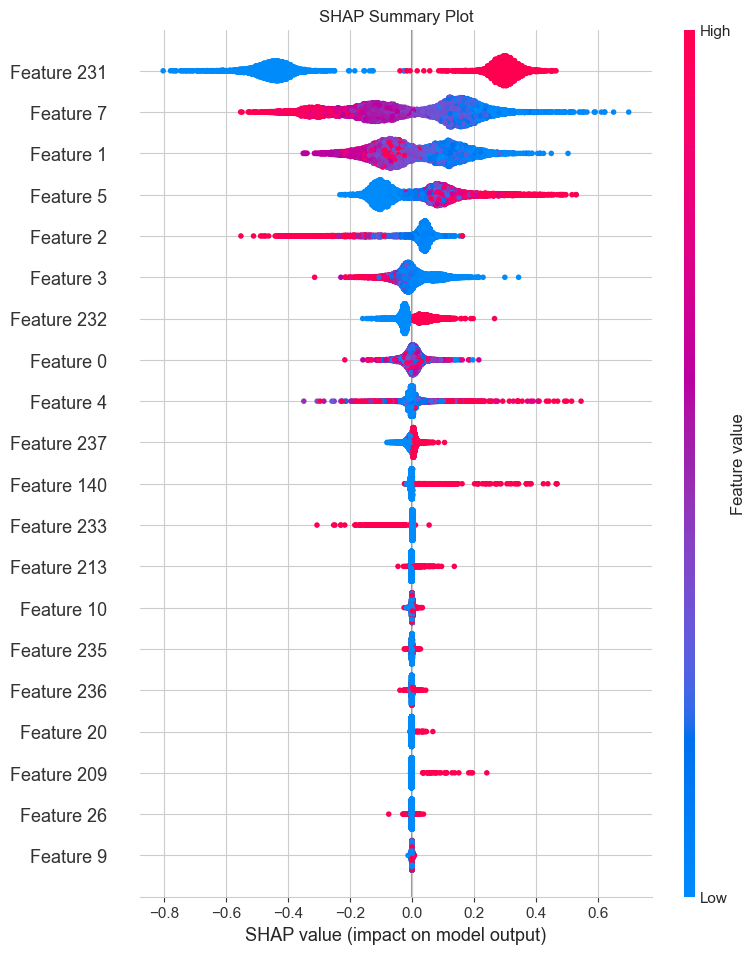

In [53]:
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values.values, X_test_transformed, show=False)
plt.title("SHAP Summary Plot")

shap_summary_path = "artifacts/shap_summary.png"
os.makedirs("artifacts", exist_ok=True)
plt.savefig(shap_summary_path, bbox_inches='tight')
plt.close()

print("SHAP summary plot saved.")
from IPython.display import Image, display
display(Image(filename="artifacts/shap_summary.png"))

### Observation
The model's predictions are overwhelmingly driven by Feature 231, which acts as a powerful binary switch: high values of Feature 231 significantly increase the prediction (positive SHAP values), and low values significantly decrease it (negative SHAP values). Other features, like Feature 7 and Feature 1, have strong influence but are much more complex, showing varying impact across their range of values

### 7. SHAP Dependence Plot (Top Feature)

SHAP dependence plot saved.


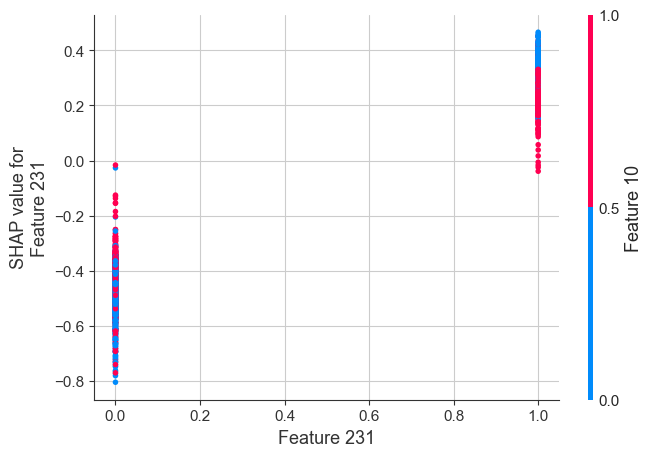

<Figure size 800x500 with 0 Axes>

In [54]:
# Identify most important feature by SHAP mean magnitude
mean_shap = np.abs(shap_values.values).mean(axis=0)
top_feature_idx = np.argmax(mean_shap)

plt.figure(figsize=(8,5))
shap.dependence_plot(top_feature_idx, shap_values.values, X_test_transformed, show=False)

shap_dependence_path = "artifacts/shap_dependence.png"
plt.savefig(shap_dependence_path, bbox_inches='tight')
plt.close()

print("SHAP dependence plot saved.")
display(Image(filename="artifacts/shap_dependence.png"))

### Observation 
Feature 231 is a binary (0 or 1) categorical feature that is highly influential on the model's output. When Feature 231 is 0, the prediction is generally much lower (negative SHAP values, clustering around -0.8), and when Feature 231 is 1, the prediction is generally much higher (positive SHAP values, clustering around +0.4).

### 8. Log Explainability Plots to MLflow

In [48]:
with mlflow.start_run(run_id=best_run_id):
    mlflow.log_artifact(shap_summary_path)
    mlflow.log_artifact(shap_dependence_path)

print("Explainability artifacts logged to MLflow.")


🏃 View run RegisterBestModel at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/e07f70d3619b41d89ebe09fb1a55ff61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588
Explainability artifacts logged to MLflow.


### 9. Residuals Plot

Residuals plot saved.


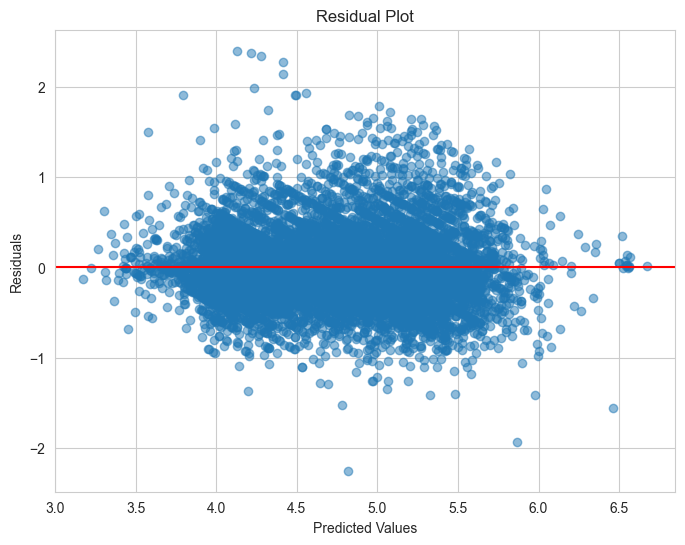

In [55]:
residuals = y_test - preds

plt.figure(figsize=(8,6))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

residual_plot_path = "artifacts/residuals.png"
plt.savefig(residual_plot_path, bbox_inches='tight')
plt.close()

print("Residuals plot saved.")
display(Image(filename="artifacts/residuals.png"))

### Observation
The model exhibits heteroscedasticity and potential non-linearity. The plot shows the spread of the residuals is not constant (heteroscedasticity) and suggests a slight fan-out pattern . Specifically, the residuals appear to be more tightly clustered around 0 for the lowest predicted values ($\sim 3.0$ to $4.0$) and spread out significantly as the predicted values increase ($\sim 4.5$ to $6.0$).

### 10. Log Residuals Plot to MLflow

In [50]:
with mlflow.start_run(run_id=best_run_id):
    mlflow.log_artifact(residual_plot_path)

print("Residual plot logged to MLflow.")


🏃 View run RegisterBestModel at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/e07f70d3619b41d89ebe09fb1a55ff61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588
Residual plot logged to MLflow.


### 11. Example Predictions Table (20 Samples)

In [51]:
sample_df = pd.DataFrame({
    "actual": y_test[:20],
    "predicted": preds[:20]
})

sample_table_path = "artifacts/sample_predictions.csv"
sample_df.to_csv(sample_table_path, index=False)

with mlflow.start_run(run_id=best_run_id):
    mlflow.log_artifact(sample_table_path)

sample_df


🏃 View run RegisterBestModel at: http://127.0.0.1:5000/#/experiments/236889159921577588/runs/e07f70d3619b41d89ebe09fb1a55ff61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236889159921577588


,actual,predicted
7166,5.733341,5.270731
44914,5.298317,4.998447
26665,5.081404,5.065453
37577,4.077537,3.503158
36314,4.219508,4.387779
21886,4.795791,4.752098
35030,4.983607,4.712620
32231,4.343805,4.471892
24258,5.620401,4.877707
10157,3.871201,3.888321


### Observation
The model exhibits a conservative prediction bias, tending to overestimate the lowest actual values and underestimate the highest actual values. This is evident in the two largest errors: a significant underestimation of the high value ($5.62$ actual vs. $4.88$ predicted) and a noticeable overestimation of a low value ($3.47$ actual vs. $4.11$ predicted). The model struggles with the data's extremes.

## Recommendations for StayWise

Integrate the model into host onboarding to generate real-time pricing suggestions.

Schedule monthly automated retraining through MLflow for model freshness.

Enrich training data with additional spatial features, seasonal trends, and host response rates.

Consider future expansion into time-series dynamic pricing models.

## Conclusion

This project delivers a robust, reproducible workflow for predicting Airbnb listing prices using AWS S3, MLflow, and modern machine learning techniques.
By applying strong preprocessing, thoughtful feature engineering, and meticulous model tracking, the solution provides clear predictive capability and business value for StayWise.

